# 地铁人流量预测
From Udacity Data Science Final project

## Introduction

Can we predict how many people will use the metro in New York City (NYC) at any given time? In particular in this article we will explore whether the current weather conditions help predict the number of people entering and exit subway stations.

Answering this question could help the Metro Transit Authority (MTA) in NYC save money and make the metro safer. More accurate predictions of how many people will visit certain stations could allow the MTA to better assign staff and predict rush periods that otherwise would be unexpected.

Thie article will both answer this question and introduce readers to the basics of data science. We will:

- explore a large and complex set of data, using numeric and visual techniques.
- use appropriate statistical methods to develop meaningful answers to questions
- use basic machine learning methods to develop and test predictive models of data
- understand what MapReduce is and how it would help in processing larger amounts of data.

### Prerequisites

A full understanding of this article requires a background in mathematics and statistics. If you have followed the "Intro to Data Science" course on Udacity you have this background.

You can still follow this article without such a background but don't fret if many details don't make sense!

## 0. Imports that allow the Python code to work

In [1]:
from __future__ import division

import datetime
import itertools
import operator

import brewer2mpl
import ggplot as gg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats
import statsmodels.api as sm

%matplotlib inline

## 1. Obtaining and cleaning data

Getting data and cleaning it up into a state suitable for analysis is difficult and time consuming. In fact for the typical data scientist this task will occupy the majority of their time.

For this article data on MTA ridership during May 2011 comes from:

http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt

The weather data covering the same period comes from Weather Underground:

https://www.dropbox.com/s/7sf0yqc9ykpq3w8/weather_underground.csv

To save you some time here is a combination of these two data sets all cleaned up for you

In [6]:
!rm -f turnstile_data_master_with_weather.csv
#!wget --no-verbose https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
!wget --no-verbose https://raw.githubusercontent.com/allanbreyes/udacity-data-science/master/p1/ps3/turnstile_data_master_with_weather.csv

2016-11-01 15:03:36 URL:https://raw.githubusercontent.com/allanbreyes/udacity-data-science/master/p1/ps3/turnstile_data_master_with_weather.csv [15990662/15990662] -> "turnstile_data_master_with_weather.csv" [1]


The data is in a regular CSV file, the kind which you can open in Microsoft Excel and see a large number of columns for:

In [2]:
with open("turnstile_data_master_with_weather.csv") as f_in:
    for i in xrange(3):
        print f_in.readline().strip()

,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,mindewpti,minpressurei,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,R001,2011-05-01,01:00:00,1,REGULAR,0.0,0.0,30.31,42.0,35.0,30.23,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
1,R001,2011-05-01,05:00:00,5,REGULAR,217.0,553.0,30.31,42.0,35.0,30.23,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0


However, we're going to use the pandas library to make it much easier to analyse and chart the data contained in this CSV file.

In [3]:
turnstile_data = pd.read_csv("turnstile_data_master_with_weather.csv")
turnstile_data.head()

,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0.0,0.0,30.31,42.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217.0,553.0,30.31,42.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890.0,1262.0,30.31,42.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451.0,3708.0,30.31,42.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400.0,2501.0,30.31,42.0,...,39.0,30.27,0.0,0.0,5.0,50.0,60.0,69.0,0.0,0.0


For convenience we add a new column that combines the date and time columns. This will make our plotting just below a little easier:

In [4]:
turnstile_data["DATETIMEn"] = pd.to_datetime(turnstile_data["DATEn"] + " " + turnstile_data["TIMEn"], format="%Y-%m-%d %H:%M:%S")

## 2. Exploring data

The first question we always try answer is "what does it look like?". Let's plot the number of people who enter and exit all metro stations throughout NYC over time:

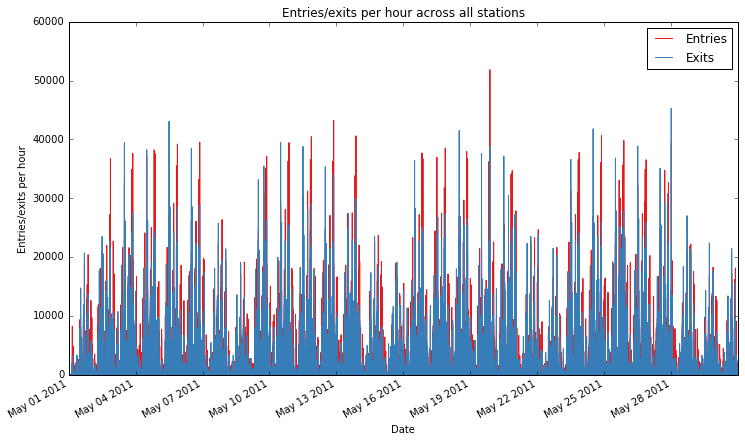

In [5]:
turnstile_dt = turnstile_data[["DATETIMEn", "ENTRIESn_hourly", "EXITSn_hourly"]] \
               .set_index("DATETIMEn") \
               .sort_index()
fig, ax = pylab.subplots(figsize=(12, 7))
set1 = brewer2mpl.get_map('Set1', 'qualitative', 3).mpl_colors
turnstile_dt.plot(ax=ax, color=set1)
ax.set_title("Entries/exits per hour across all stations")
ax.legend(["Entries", "Exits"])
ax.set_ylabel("Entries/exits per hour")
ax.set_xlabel("Date")
pass

From this chart we can already tell that:

- some days are less busy than others, but it's difficult to tell which days in particular are less busy, and
- there seems to be several spikes per day in both entries and exits, but it's difficult to tell when these spikes occur.

Time to dig in a bit deeper. Firstly, let's see how the day of the week affects the number of entries/exits per hour:

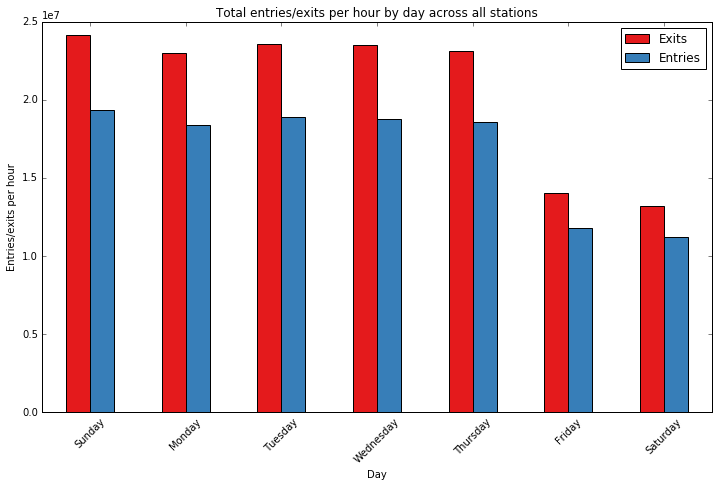

In [6]:
turnstile_day = turnstile_dt
turnstile_day["day"] = turnstile_day.index.weekday
turnstile_day = turnstile_day[["day", "ENTRIESn_hourly", "EXITSn_hourly"]] \
            .groupby("day") \
            .agg(sum)

fig, ax = plt.subplots(figsize=(12, 7))
set1 = brewer2mpl.get_map('Set1', 'qualitative', 3).mpl_colors
turnstile_day.plot(ax=ax, kind="bar", color=set1)
ax.set_title("Total entries/exits per hour by day across all stations")
ax.legend(["Exits", "Entries"])
ax.set_ylabel("Entries/exits per hour")
ax.set_xlabel("Day")
ax.set_xticklabels(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
                   rotation=45)
pass

Fridays and Saturdays are the least busy days.

Secondly, we want to plot the total hourly entries and exits per hour grouped by hour to see which hours are more busy than others. Our data however won't make this easy, because it's only sampled once every four hours (1AM, 5AM, 9AM, ...). We need to resample our data and guess what the entries/exits for e.g. 2AM, 3AM, etc would be, and we guess these values by "drawing straight lines" between known values.

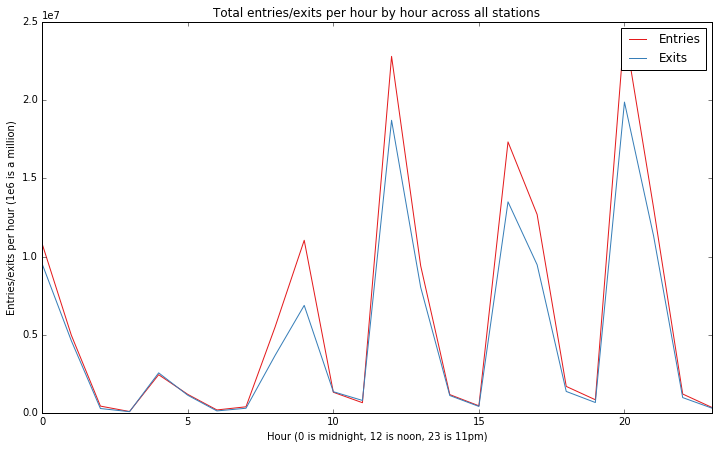

In [7]:
turnstile_dt["hour"] = turnstile_dt.index.hour
turnstile_by_hour = turnstile_dt
turnstile_by_hour = turnstile_by_hour[["hour", "ENTRIESn_hourly", "EXITSn_hourly"]] \
            .groupby("hour") \
            .sum()

fig, ax = pylab.subplots(figsize=(12, 7))
set1 = brewer2mpl.get_map('Set1', 'qualitative', 3).mpl_colors
turnstile_by_hour.plot(ax=ax, color=set1)
ax.set_title("Total entries/exits per hour by hour across all stations")
ax.legend(["Entries", "Exits"])
ax.set_ylabel("Entries/exits per hour (1e6 is a million)")
ax.set_xlabel("Hour (0 is midnight, 12 is noon, 23 is 11pm)")
ax.set_xlim(0, 23)
pass

By plotting the total number of hourly entries and exits grouped by hour we can see that there are indeed several spikes during the day. Since we had to fill in the blanks to draw this chart though it's not worth reading too much into this chart; higher precision data would make this chart far more useful.

Rather than dividing up our data by hour and day, looking at all of it at once what effect does rain have on the number of people who use the subway? Our Weather Underground data has a "rain" column that is 0 if it wasn't raining, 1 if it was, during a particular hourly turnstile measurement:

In [8]:
turnstile_rain = turnstile_data[["rain", "ENTRIESn_hourly", "EXITSn_hourly"]]
turnstile_rain["rain2"] = np.where(turnstile_rain["rain"] == 1, "raining", "not raining")
turnstile_rain.groupby("rain2").describe()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


ENTRIESn_hourly  EXITSn_hourly     rain
rain2                                                     
not raining count     87847.000000   87847.000000  87847.0
            mean       1090.278780     883.259610      0.0
            std        2320.004938    1998.516762      0.0
            min           0.000000       0.000000      0.0
            25%          38.000000      31.000000      0.0
            50%         278.000000     231.000000      0.0
            75%        1111.000000     846.000000      0.0
            max       43199.000000   45249.000000      0.0
raining     count     44104.000000   44104.000000  44104.0
            mean       1105.446377     894.123572      1.0
            std        2370.527674    2028.552487      0.0
            min           0.000000       0.000000      1.0
            25%          41.000000      33.000000      1.0
            50%         282.000000     235.000000      1.0
            75%        1103.250000     849.000000      1.0
            max       51839.000000   41503.000000      1.0

The median and mean number of entries and exits per hour are higher when it is raining than when it is not raining. The numeric difference however is very small, as show below when we plot Kernel Density Estimates (KDEs) of the data. A KDE can be thought of as a "smooth histogram", but more formally is an estimate of the probability distribution function (PDF) of our data, i.e. "at this point here what is the probability from [0, 1) of this value occurring?".

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


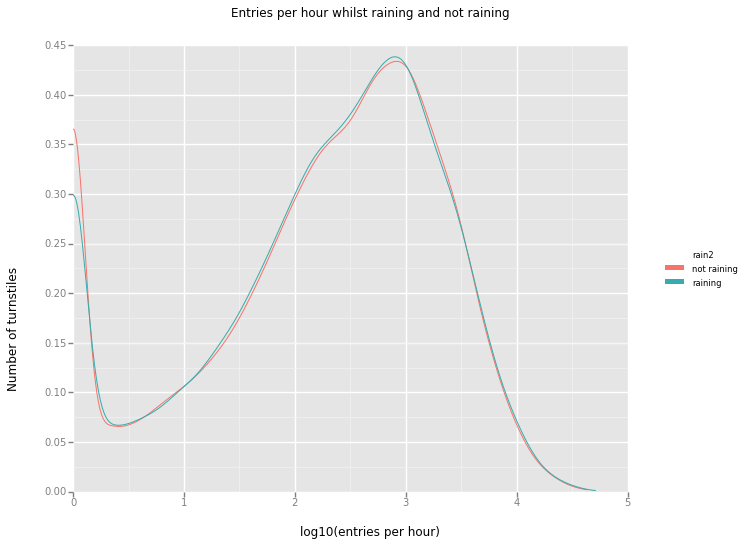

<ggplot: (289702045)>

In [9]:
turnstile_rain = turnstile_data[["rain", "ENTRIESn_hourly", "EXITSn_hourly"]]
turnstile_rain["ENTRIESn_hourly_log10"] = np.log10(turnstile_rain["ENTRIESn_hourly"] + 1)
turnstile_rain["rain2"] = np.where(turnstile_rain["rain"] == 1, "raining", "not raining")
set1 = brewer2mpl.get_map('Set1', 'qualitative', 3).mpl_colors
plot = gg.ggplot(turnstile_rain, gg.aes(x="ENTRIESn_hourly_log10", color="rain2")) + gg.geom_density()  + gg.xlab("log10(entries per hour)") + gg.ylab("Number of turnstiles") + gg.ggtitle("Entries per hour whilst raining and not raining")
plot

Note what we've plotted on the x-axis. This time we didn't plot the number of entries per hour by itself, but rather applied "log10" (log base 10) to it. That means that 0 = 1, 1 = 10, 2 = 100, 3 = 1000, 4 = 1000, and 5 = 10000. Plotting it this way makes it easier to fit in data with extreme values in the same chart.

log10 came in handy, because a lot of turnstiles are idle during the day! Applying a function to our data and then charting it allows us to still use charts to visualise strange data. This is a very common technique in, for example, electrical engineering, where you often deal with both very small and very large numbers at the same time.

Although our numeric estimate above indicates that more people travel per hour when it is raining, this conclusion isn't clear when looking at these charts. However drawing a KDE gives us another interesting perspective: the "pattern" of the numbers of people traveling on the MTA doesn't change according to the rain. It isn't as if the MTA, or the way people use it, magically changes when it starts raining.

## 2. Analysing data

We sounded very confident above when we said that more people ride the subway when it's raining. Rather than relying on a chart, is there a numerical way of seeing how sure we are that there is a difference?

This is a common statistical problem. Given two groups of data you need to figure out whether they have the same averages or not. We have a vertiable goody bag full of statistical techniques which will let us answer this question. However different techniques make different assumptions!

One method, the t-test, assumes that the data we're analysing is "normal". What does normal mean? Data like the heights of people in a room often look like this:

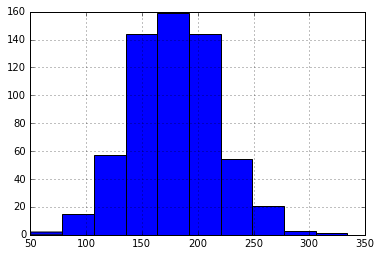

In [10]:
np.random.seed(42)
data = pd.Series(np.random.normal(loc=180, scale=40, size=600))
data.hist()
pass

Notice how it's neatly symmetrical, with only one peak in the middle? You may also know this as the "bell curve". However, it's clear that our data is not normally distributed:

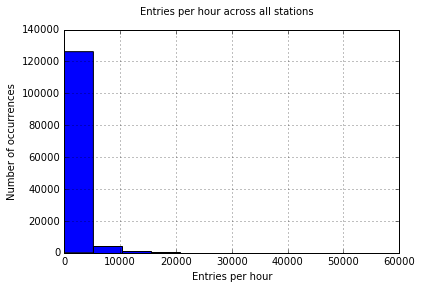

In [11]:
p = turnstile_data["ENTRIESn_hourly"].hist()
pylab.suptitle("Entries per hour across all stations")
pylab.xlabel("Entries per hour")
pylab.ylabel("Number of occurrences")
pass

Again, though, the purpose of this section is to use numerical methods for answering our questions. Posed the question "Is my data normally distributed, so that I can use the t-test on it?" we can do the following:

In [12]:
(k2, pvalue) = scipy.stats.normaltest(turnstile_data["ENTRIESn_hourly"])
print pvalue

0.0


Here we've avoided using the Shapiro-Wilk test (`scipy.stats.shapiro`) because it does not work for data sets with more than 5000 values. Moreover, this test has returned a pvalue of close to 0, meaning that it is very likely that the data is not normally distributed. That means we can't use the t-test!

Bummer! Fortunately, another test, the Mann-Whitney U test, doesn't assume the data is normally distributed and lets us answer the same question. Let's give it a whirl!

In [13]:
not_raining = turnstile_data[turnstile_data["rain"] == 0]
raining = turnstile_data[turnstile_data["rain"] == 1]
(u, pvalue) = scipy.stats.mannwhitneyu(not_raining["ENTRIESn_hourly"],
                                       raining["ENTRIESn_hourly"])
print "median entries per hour when not raining: %s" % not_raining["ENTRIESn_hourly"].median()
print "median entries per hour when raining: %s" % raining["ENTRIESn_hourly"].median()
print "p-value of test statistic: %.4f" % (pvalue * 2, )

median entries per hour when not raining: 278.0
median entries per hour when raining: 282.0
p-value of test statistic: 0.0500


Since `scipy.stats.mannwhiteneyu` returns a one-sided p-value, and we did not predict which group would have a higher average before we gathering any data, we must multiply it by two to give a two-sided p-value \[1\] \[2\]. Using this allows us to say that, with a 5% degree of certainty, that there is a difference in the average number of entries per hour depending on whether it's raining or not \[3\].

## 3. Creating and evaluating models of data

Both by drawing a variety of charts and using some statistical tests we've determined that the day, hour of day, and whether its raining affects the number of people riding the MTA. However, our original goal was to predict how many people use the metro in NYC at any given time. Given that we know we have some information available that can help us answer this question, but we're not precisely sure how this data maps onto our desired results, what is the best next step?

In machine learning the task of predicting a continuous variable like height, weight, number of entries per hour, etc. is called **regression**. We're going to a simple method called linear regression to attempt to predict the number of entries per hour using variables we've already confirmed using charts as having an effect on subway ridership:

- the amount of rain falling ('precipi'),
- the hour of the day (0 to 23 inclusive) ('Hour')
- the mean temperature in Fahrenheit as an integer ('meantempi')
- which particular metro station we're trying to predict ridership for ('UNIT').

The last feature is odd because is a **categorical variable**, some choice amongst a handful, akin to handedness, colour, etc. In order to represent a categorical variable in our numerical model we turn it into a set of **dummy variables**. For a categorical variable with *n* possible values we create *n* new columns, where only one of the columns can be 1 for a particular row, else is 0. For example if we had a categorical variable called "handedness" with possible values "left" and "right" we'd add two columns, "handedness_left" and "handedness_right", where only one of the columns could be 1 for a given row.

In linear regression we have:

- A set of inputs called **features**, X. In here we put all our input variables and a column of 1's, to allow a constant value to be used.
- A set of outputs called **values**, y. Here we'll be predicting ENTRIESn_hourly.
- Values **theta** we get to choose to map one row of features onto a single value.

Formally we say that:

$
\begin{aligned}
y &= \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n \\
&= \vec{\theta}^{T} \vec{x}
\end{aligned}
$

In our case:

$
\vec{x}_i =
\begin{bmatrix}
1 \\ \textrm{precipi}_i \\ \textrm{Hour}_i \\ \textrm{meantempi}_i \\
\textrm{UNIT}_{1i} \\
\textrm{UNIT}_{2i} \\
\ldots \\
\textrm{UNIT}_{ni} \\
\end{bmatrix}
$

So to be clear what we're trying to figure out is some values for $\vec{\theta}$ that'll let us make a model such that:

$
\begin{aligned}
\textrm{ENTRIESn_HOURLY} &= \theta_0 \\ &+ \theta_1 \times \textrm{precipi} \\ &+ \theta_2 \times \textrm{Hour} \\ &+ \theta_3 \times \textrm{meantempi} \\ &+ \theta_4 \times \textrm{UNIT}_1 \\ &+ \theta_5 \times \textrm{UNIT}_2 \\ &+ \\ \ldots
\end{aligned}
$

In order to do this we want to find some values for $\vec{\theta}$ that minimize the **cost function** for linear regression:

$
\begin{aligned}
J(\theta) &= \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left( \textrm{predictions} - \textrm{actuals} \right) ^ 2 \\
&= \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left( \theta^T x - y \right) ^ 2
\end{aligned}
$

In [14]:
def compute_cost(features, values, theta):
    m = len(values)
    predictions = features.dot(theta)
    return (1 / (2 * m)) * np.square(predictions - values).sum()

In order to minimize the cost we start off at $\vec{\theta} = \vec{0}$ and then run a **gradient descent** step many times. Each time we run the following step we get closer and closer to the values of $\vec{\theta}$ the minimize the cost function:

$
\theta_j = \theta_j - \frac{\alpha}{m} \displaystyle \sum_{i=1}^{m} \left( \theta^T x - y \right ) x
$

Where $\alpha$ is the **learning rate**. Setting this value too small will cause us to converge very slowly but we'll always get the right answer eventually, whereas setting it too large goes faster but may cause us to *diverge* and never get the right answer!

In [15]:
def gradient_descent(features, values, theta, alpha, num_iterations):
    m = len(values)
    cost_history = []
    for i in xrange(num_iterations):
        loss = features.dot(theta) - values
        delta = (alpha/m) * loss.dot(features)
        theta -= delta
        cost_history.append(compute_cost(features, values, theta))
    return theta, pd.Series(cost_history)

One catch with using gradient descent to solve the cost function for linear regression is that if we don't use **feature scaling** to scale each input feature to the range $-1 \leq x_i \leq 1$ then it will take a very long time for our algorithm to converge. Hence we will scale our input features in order to speed up convergence, but not that this does not affect the correctness of our solution.

In [16]:
def normalize_features(array):
    mu = array.mean()
    sigma = array.std()
    normalized = (array - mu) / sigma
    return (normalized, mu, sigma)

In [17]:
def predictions(features, values, alpha, num_iterations):
    m = len(values)
    theta = np.zeros(features.shape[1])
    theta, cost_history = gradient_descent(features, values, theta, alpha, num_iterations)
    predictions = features.dot(theta)
    # Predictions less than 0 make no sense, so just set them to 0
    predictions[predictions<0] = 0
    return pd.Series(predictions)

dummy_units = pd.get_dummies(turnstile_data['UNIT'], prefix='unit')
features = turnstile_data[['rain', 'precipi', 'Hour', 'meantempi']].join(dummy_units)
features, mu, sigma = normalize_features(features)
features = np.array(features)
features = np.insert(features, 0, 1, axis=1)
values = np.array(turnstile_data[['ENTRIESn_hourly']]).flatten()
pred = predictions(features=np.array(features),
                   values=values,
                   alpha=0.1,
                   num_iterations=150)
turnstile_data[["UNIT", "DATETIMEn", "ENTRIESn_hourly"]].join(pd.Series(pred, name="predictions")).head(n=10)

,UNIT,DATETIMEn,ENTRIESn_hourly,predictions
0,R001,2011-05-01 01:00:00,0.0,3380.274237
1,R001,2011-05-01 05:00:00,217.0,3649.860482
2,R001,2011-05-01 09:00:00,890.0,3919.446727
3,R001,2011-05-01 13:00:00,2451.0,4189.032972
4,R001,2011-05-01 17:00:00,4400.0,4458.619218
5,R001,2011-05-01 21:00:00,3372.0,4728.205463
6,R002,2011-05-01 01:00:00,0.0,317.142200
7,R002,2011-05-01 05:00:00,42.0,586.728446
8,R002,2011-05-01 09:00:00,50.0,856.314691
9,R002,2011-05-01 13:00:00,316.0,1125.900936


We have some predictions, but how are we going to evaluate how good these predictions are? One simple method is to compute the **coefficient of determination**, which measure how much variability in the data your model is able to capture. It varies from 0 to 1 and bigger values are better:

$
\begin{aligned}
R^2 &= 1 - \frac{\sigma_\textrm{errors}^2}{\sigma_\textrm{data}^2} \\
&= 1 - \frac{ \displaystyle \sum_{i=1}^{m} \left( y_i - f_i \right)^2 }{ \displaystyle \sum_{i=1}^{m} \left( y_i - \bar{y}_i \right)^2 }
\end{aligned}
$

In [18]:
def compute_r_squared(data, predictions):
    numerator = np.square(data - predictions).sum()
    denomenator = np.square(data - data.mean()).sum()
    return 1 - numerator / denomenator

In [19]:
"%.3f" % compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred)

'0.465'

So loosely speaking our model identifies 46% of the variation present in the data it was trained on.

Another way of determining how good a statistical model is is to plot its **residuals**, which are defined as the differences between the predicted and actual values. Residuals are elements of variation in the data unexplained by a model. A good model's residual plot will be distributed as a Normal distribution with a mean of 0 and some finite variance \[4\].

<module 'matplotlib.pyplot' from '/Library/Python/2.7/site-packages/matplotlib/pyplot.pyc'>

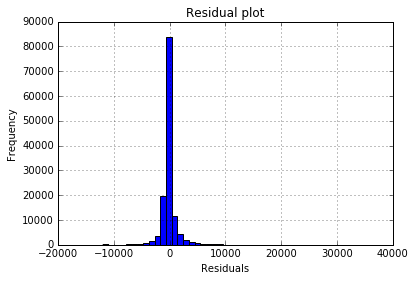

In [20]:
def plot_residuals(df, predictions):
    """Reference: http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
    """
    plt.figure()
    (df["ENTRIESn_hourly"] - predictions).hist(bins=50)
    pylab.title("Residual plot")
    pylab.xlabel("Residuals")
    pylab.ylabel("Frequency")
    return plt

plot_residuals(turnstile_data, pred)

In [21]:
residuals = turnstile_data["ENTRIESn_hourly"] - pred
(zscore, pvalue) = scipy.stats.normaltest(residuals)
print "p-value of normaltest on residuals: %s" % pvalue
print "mean of residuals: %s" % residuals.mean()

p-value of normaltest on residuals: 0.0
mean of residuals: -64.0687532787


In summary our current model seems to be quite a good fit and the residual plot indicates that there might be some structure left in our residual errors that could be reduced. 

## 4. Going Further

How can we improve our model? In general there are always two steps available to us when we need to improve the performance of some statistical model: make our model more complex, or feed it more data.

With our current linear regression model we're just passing in the original values for a small set of features. We could make our model more complex and pass in **more features** to see if that helps:

In [22]:
dummy_units = pd.get_dummies(turnstile_data['UNIT'], prefix='unit')
features = turnstile_data[['rain', 'precipi', 'Hour', 'meantempi', 'mintempi', 'maxtempi',
                           'mindewpti', 'meandewpti', 'maxdewpti', 'minpressurei',
                           'meanpressurei', 'maxpressurei', 'meanwindspdi']].join(dummy_units)
features, mu, sigma = normalize_features(features)
features = np.array(features)
features = np.insert(features, 0, 1, axis=1)
values = np.array(turnstile_data[['ENTRIESn_hourly']]).flatten()
pred2 = predictions(features=np.array(features),
                    values=values,
                    alpha=0.1,
                    num_iterations=150)
print("original R^2: %.3f" % compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred))
print("more existing features R^2: %.3f" %
      compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred2))

original R^2: 0.465
more existing features R^2: 0.467


Alternatively we can use **polynomial combinations** of features to give our linear regression model a better chance of fitting the data. One disadvantage of this approach is the number of features used increases dramatically and it'll take much longer to both train and use our model.

In [23]:
def add_polynomial_features(df, degree, add_sqrt):
    for i in xrange(2, degree + 1):
        for combination in itertools.combinations_with_replacement(df.columns, i):
            name = " ".join(combination)
            value = np.prod(df[list(combination)], axis=1)
            df[name] = value
    if add_sqrt:
        for column in df.columns:
            df["%s_sqrt" % column] = np.sqrt(df[column])

dummy_units = pd.get_dummies(turnstile_data['UNIT'], prefix='unit')
features = turnstile_data[['rain', 'precipi', 'Hour', 'meantempi', 'mintempi', 'maxtempi',
                           'mindewpti', 'meandewpti', 'maxdewpti', 'minpressurei',
                           'meanpressurei', 'maxpressurei', 'meanwindspdi']]
add_polynomial_features(features, 2, add_sqrt=True)
features = features.join(dummy_units)
features, mu, sigma = normalize_features(features)
features = np.array(features)
features = np.insert(features, 0, 1, axis=1)
values = np.array(turnstile_data[['ENTRIESn_hourly']]).flatten()
pred3 = predictions(features=np.array(features),
                    values=values,
                    alpha=0.025,
                    num_iterations=150)
print("original R^2: %.3f" % compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred))
print("more existing features R^2: %.3f" %
      compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred2))
print("more existing features with polynomial combinations R^2: %.3f" %
      compute_r_squared(turnstile_data["ENTRIESn_hourly"], pred3))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


original R^2: 0.465
more existing features R^2: 0.467
more existing features with polynomial combinations R^2: 0.472


The downside with increasing the complexity of the model is that there's a risk that our model is already complex enough, and instead we need to feed it more data. In order to gather and process large amounts of data we may have to resort to a concurrency model like MapReduce, where massive amounts of data are processed by many computers that don't communicate with one another but instead write to a shared file system.

How can we tell whether our model is complex enough? In machine learning terms this is referred to as the **bias/variance** problem:

- If our model is experiencing high bias it is underfitting the data and not fitting the data well enough. Adding more data will not help because the model is already unable to model the data. Instead you need to make the model more complex.
- If our model is experiencing high variance it is overfitting the data and too complex. Adding more data will help because this makes the data more complex and reduces the likelihood of the model overfitting the data.

In order to determine whether our model is experiencing high bias or high variance we plot **learning curves**:

- Rather than training our model on all available data we split the data set into three pieces: a **training set**, a **cross-validation** set, and a **testing** set.
- A good default split of around 60% training, 20% cross-validation, and 20% testing. In our case since we're just drawing learning curves and not evaluating our model's generalizability let's set it to 60% training and 40% cross validation.
- Plot $J_\textrm{CV}(\theta)$ and $J_\textrm{train}(\theta)$ with respect to the number of training samples. Whilst feeding in an ever increasing amount of training samples, re-train for new values of $\theta$ and plot the cost function on the training set ($J_\textrm{train}(\theta)$) and the cross-validation set ($J_\textrm{CV}(\theta)$).
- If $J_\textrm{CV}(\theta) \approx J_\textrm{train}(\theta)$ as the number of samples increases then you have high bias. The model isn't able to capture patterns in the data.
- If $J_\textrm{CV}(\theta) >> J_\textrm{train}(\theta)$ it's likely that your model is complex enough and overfitting your training data. Increasing the number of training samples will help improve your model's performance.

In [24]:
def get_shuffled_df(df):
    m = len(turnstile_data)
    df = turnstile_data.copy()
    df = df.reindex(np.random.permutation(df.index))
    return df

np.random.seed(42)
df = get_shuffled_df(turnstile_data)

In [25]:
m = len(df)
df_train = df[:int(0.6*m)]
df_cv = df[int(0.6*m):]

feature_names = ['rain', 'precipi', 'Hour', 'meantempi']
value_name = 'ENTRIESn_hourly'

dummy_units = pd.get_dummies(df_train['UNIT'], prefix='unit')
features_train = df_train[feature_names].join(dummy_units)
features_train, mu, sigma = normalize_features(features_train)
features_train = np.array(features_train)
features_train = np.insert(features_train, 0, 1, axis=1)
values_train = df_train[value_name]

dummy_units = pd.get_dummies(df_cv['UNIT'], prefix='unit')
features_cv = df_cv[feature_names].join(dummy_units)
features_cv = (features_cv - mu) / sigma
features_cv = np.array(features_cv)
features_cv = np.insert(features_cv, 0, 1, axis=1)
values_cv = df_cv[value_name]

In [26]:
def get_learning_curves(features_train, values_train, features_cv, values_cv,
                        num_points=10, alpha=0.1, num_iterations=50):
    cost_train = []
    r_squared_train = []
    cost_cv = []
    r_squared_cv = []
    m = len(features_train)
    number_of_samples = np.array(np.linspace(m/num_points, m - 1, num_points), dtype=np.int)        
    for i in number_of_samples:
        features_train_subset = features_train[:i]
        values_train_subset = values_train[:i]
        theta = np.zeros(features_train_subset.shape[1])
        theta, _ = gradient_descent(features_train_subset, values_train_subset, theta, alpha, num_iterations)
        cost_train_subset = compute_cost(features_train_subset, values_train_subset, theta)
        cost_train.append(cost_train_subset)
        r_squared_train.append(compute_r_squared(values_train_subset, features_train_subset.dot(theta)))
        cost_cv_subset = compute_cost(features_cv, values_cv, theta)
        cost_cv.append(cost_cv_subset)
        r_squared_cv.append(compute_r_squared(values_cv, features_cv.dot(theta)))
    return pd.DataFrame({'Number of samples': number_of_samples,
                          'Training error': cost_train,
                          'Testing error': cost_cv,
                          'R^2 training': r_squared_train,
                          'R^2 testing': r_squared_cv})

np.random.seed(42)
costs = get_learning_curves(features_train, values_train, features_cv, values_cv)

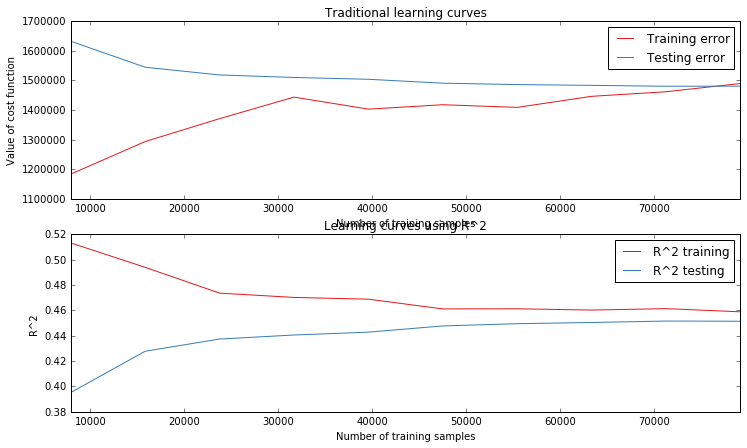

In [27]:
fig, (ax1, ax2) = pylab.subplots(nrows=2, ncols=1, figsize=(12, 7))
set1 = brewer2mpl.get_map('Set1', 'qualitative', 3).mpl_colors
costs.plot(x="Number of samples", y=['Training error', 'Testing error'],
           ax=ax1, color=set1)
ax1.set_title("Traditional learning curves")
ax1.legend()
ax1.set_xlabel("Number of training samples")
ax1.set_ylabel("Value of cost function")
costs.plot(x="Number of samples", y=["R^2 training", "R^2 testing"],
           ax=ax2, color=set1)
ax2.set_title("Learning curves using R^2")
ax2.legend()
ax2.set_xlabel("Number of training samples")
ax2.set_ylabel("R^2")
pass

If you're confused as to why the training error can exceed the testing error, note that this is probably random error at play. A more robust drawing of the learning curves would use bootstrapping to estimate the values of the cost function on the training and testing sets, rather than using a single sample.

Looking at a non-traditional set of learning curves that use the coefficient of determination $R^2$ instead it's clear that our current model is experiencing high bias. The training and testing coefficients of determination are almost equal and not really changing with respect to the number of samples. Hence we would not expect gathering more training data to improve our learning algorithm's performance. Instead we should focus on increasing its complexity, as we were doing above by e.g. adding polynomial features. Alternatively one could use more advanced regression techniques such as neural networks or Support Vector Regression (SVR).

However another unfortunate possibility is that the features available to us, relating to the weather, do not contain enough information to better predict the ridership of the MTA. It is a difficult judgement to make as to whether this is true.

### 为什么不试试xgboost呢

In [29]:
features_train.shape

(79170, 470)

In [30]:
values_train.shape

(79170,)

In [31]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

params = [3,5,6,9]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, features_train, values_train, cv=3, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

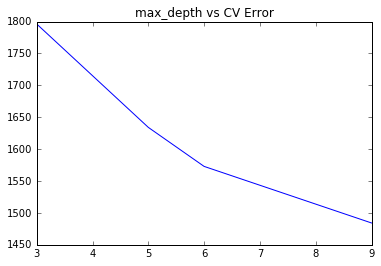

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");

## 5. References

\[1\] scipy.stats.mannwhiteyu (http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)  

\[2\] One tail vs Two tail p-values (http://graphpad.com/guides/prism/6/statistics/index.htm?one-tail_vs__two-tail_p_values.htm)  

\[3\] How the Mann-Whitney Test Works (http://graphpad.com/guides/prism/6/statistics/index.htm?how_the_mann-whitney_test_works.htm)  

\[4\] Are the model residuals well behaved? NIST Engineering Handbook. (http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm)

In [29]:
%autosave 10

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

Autosaving every 10 seconds
